# A STUDY ON FINANCIAL PRODUCT CONSUMER COMPLAINTS 
   **Consumer conplaints analysis, natrual language processing and predicting dispute.**

# Table of Contents

1. [Introduction](#intro)  
    1.1 [Problem](#p)   
    1.2 [Target Readers](#tr)  
    1.4 [Key Takeaway](#kt)  
    1.3 [Data Source](#ds)  
2. [Import Modules](#import)
3. [Data Wrangling](#wrangle)  
    3.1 [Import Data](#id)  
    3.2 [Correct Feature](#cf)
4. [Exploratory Data Analysis ](#eda)  
    4.1 [Analysing complaints by the month and the day of the week](#mad)  
    4.2 [State comparison of consumer complaints](#sccc)  
    4.3 [Issues Wordcloud](#iwc)  
    4.4 [Companies and responses](#cpr) 
5. [Machine Learning](#ml)  
    5.1 [Feature Engineering](#fe)  
    5.2 [Feature Selection](#dpsp)  
    5.2 [Natural Language Processing](#nlp)  
    5.3 [Predicting Consumer Dispute](#pcd)  
6. [Summary](#summary)
 

<a id='intro'></a>
## Introduction

<a id='p'></a>
### Problem: 
Financial companies rely on their products and services to generate profit and strive. One of the
key factors is the satisfaction of their customers. Without data, it is difficult to measure and
compare the level of satisfaction and expose areas needed to be improved. The Consumer
Financial Protection Bureau (CFPB) has been accepting consumer complaints of financial
products and services since 2011. These complaints are sent to companies for response.  

Consumer complaint data could be a great way to spot apparent issues and understand trends
in customers’ needs. It could be a supporting evidence when analyzing customers' satisfaction
level toward a product or service. It can also give insight in ways to improve their products and
customer satisfaction.  

The consumer complaints data also accept dispute over the response. Whether
a complaint was disputed is recorded. Can we use machine learning
models to predict whether a company response of a complaint will be disputed based on the
data set? If the top contributions to disputes can be found, companies can take proactive
means to lessen the dispute rate. This adds another perspective into promote customer service
and satisfaction. 

<a id='tr'></a>
### Target Readers:
* **FINANCIAL COMPANIES**:   
    Use this report to find insight into problems that people are experiencing, help identify inappropriate practices. The trends in the timing and location of the complaints would be valuable information for companies hoping to proactively improve their performance by keeping the customers happy.     
    
    
* **STATE AND FEDERAL AGENCIES**: 
    Take the report data as an indicator of the quality of financial products by the companies. It could provide evidence for certain market regulations.   
    
    
* **CUSTOMERS OF FINANCIAL PRODUCTS**:  
     Consider this report as a reference for choosing a company for a certain financial product or service. 

<a id='kt'></a>
### Key Takeaway:   
* Credit reporting and other consumer reports, mortgage, and debt collection are the most complained products. 
* The surge in number of complaints on credit reporting in 2017 aligns with the timing when Equifax had its major data breach.
* Counter-intuitively, less concentratated complaint durations tend to result in higher dispute rate. 
* Companies could proactively prepare or modify their reply to the complaint to improve consumer experience. 
* The top contributions were found using feature importance analysis after classifying consumer dispute.

<a id='ds'></a>
### Data Source:
The financial customer complaint data can be downloaded on the CFPB website, consumer complaint database: https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data  

The data set contains up-to-date (of this study) record of customer complaints since 2011. Its total size is 560.9 MB. The table explaining all the features of the data can be found here:
https://cfpb.github.io/api/ccdb/fields.html

<a id='import'></a>
## Import Modules

In [1]:
# import important stuff
import numpy as np
import pandas as pd

from itertools import compress

In [2]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline


import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 

In [3]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

In [4]:
# import word cloud module 
from os import path
from wordcloud import WordCloud

# import datetime
from datetime import datetime
import time

In [5]:
# import stats modules
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
from scipy.sparse import hstack

<a id='wrangle'></a>
## Data Wrangling

<a id='id'></a>
### Import Data

The consumer complaints data is a csv file sized more than 500MB. This exceeds the data maximum size on Github. I divided the original data to less than 100MB sets so it could successfully upload to the project repo. Here I import these csv files and merge them back together. 

In [6]:
# file names to import
csv_names=['consumer_complaints0.csv',
 'consumer_complaints1.csv',
 'consumer_complaints2.csv',
 'consumer_complaints3.csv',
 'consumer_complaints4.csv',
 'consumer_complaints5.csv',
 'consumer_complaints6.csv',
 'consumer_complaints7.csv',
 'consumer_complaints8.csv']

In [7]:
# read and merge the series of data 
merged = []

for i in csv_names:
    read = pd.read_csv('./../data/'+ i, parse_dates=['Date received', 'Date sent to company'])
    merged.append(read)


In [8]:
# Overlook of the data set
df = pd.concat(merged).reset_index()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045879 entries, 0 to 1045878
Data columns (total 20 columns):
index                           1045879 non-null int64
Unnamed: 0                      1045879 non-null int64
Date received                   1045879 non-null datetime64[ns]
Product                         1045879 non-null object
Sub-product                     810709 non-null object
Issue                           1045879 non-null object
Sub-issue                       546572 non-null object
Consumer complaint narrative    287655 non-null object
Company public response         328726 non-null object
Company                         1045879 non-null object
State                           1033329 non-null object
ZIP code                        1028872 non-null object
Tags                            144084 non-null object
Consumer consent provided?      508898 non-null object
Submitted via                   1045879 non-null object
Date sent to company            1045879 non-nul

A quick look at the information shows there are more than one million entries of consumer complaints. It also reveals that some of the features contain more null inputs, such as tags, sub-issues, company public response and etc.. 

<a id='cf'></a>
### Construct Features

First we take a closer look at one of the columns: "Product". The table below shows the value counts of each eighteen unique entries. The list of products includes "Prepaid card", "Credit card", "Credit card or prepaid card", and etc. It is interesting that many of the entries seem overlapping with each other. This introduce confusion in analyzing the data.   

In [9]:
#how many complaints for each financial product?
df_product = pd.DataFrame(df['Product'].value_counts()).reset_index()
df_product.columns = ['Product','Complaints Count']

In [10]:
# year of the complaint
df['Year'] = df['Date received'].apply(lambda x: x.year)

In [11]:
# The product list above seem overlapping with each other. 
# Check the appearance year of the complaints for each product. 

df.groupby('Product')['Year'].value_counts(normalize=True).unstack()

Year,2011,2012,2013,2014,2015,2016,2017,2018
Product,,,,,,,,
Bank account or service,NaN,0.141661,0.155302,0.170081,0.198826,0.253439,0.080690,NaN
Checking or savings account,NaN,NaN,NaN,NaN,NaN,NaN,0.616142,0.383858
Consumer Loan,NaN,0.062838,0.098624,0.172663,0.249549,0.303813,0.112514,NaN
Credit card,0.014127,0.172136,0.146932,0.156675,0.193966,0.236190,0.079974,NaN
Credit card or prepaid card,NaN,NaN,NaN,NaN,NaN,NaN,0.617147,0.382853
Credit reporting,NaN,0.013337,0.102398,0.208206,0.244052,0.313893,0.118113,NaN
"Credit reporting, credit repair services, or other personal consumer reports",NaN,NaN,NaN,NaN,NaN,NaN,0.616723,0.383277
Debt collection,NaN,NaN,0.055126,0.194966,0.197964,0.201590,0.238917,0.111438
"Money transfer, virtual currency, or money service",NaN,NaN,NaN,NaN,NaN,NaN,0.529851,0.470149


The table above shows the yearly product count. Many of the products in the list were changed over the years. For example, credit card, prepaid card were in earlier years but stopped (NaN) after 2017. Instead Credit card or prepaid card feature only appears in later years. So next, I combine some of the products to simplify the product feature. This also makes the column more consistent over the years. 

In [12]:
#Many products seem to be replications. Define a function here to fix that.
def categorize_feature(ls):
    new_ls = []
    for i, prod in enumerate(ls):
        if prod in ['Credit reporting', 'Credit reporting, credit repair services, or other personal consumer reports']:
            new_ls.append('Credit reporting, or other consumer reports')
        elif prod in ['Credit card', 'Prepaid card', 'Credit card or prepaid card']:
            new_ls.append('Credit card or prepaid card')
        elif prod in ['Student loan', 'Consumer Loan', 'Vehicle loan or lease', 'Payday loan', 'Payday loan, title loan, or personal loan']:
            new_ls.append('Personal loans')
        elif prod in ['Money transfer, virtual currency, or money service', 'Money transfers', 'Virtual currency']:
            new_ls.append('Money transfer, virtual currency, or money service')
        elif prod in ['Checking or savings account', 'Bank account or service']:
            new_ls.append('Bank account or service')
        else:
            new_ls.append(prod)
    return new_ls

new_list = categorize_feature(df['Product'])

How many complaints per product:
Credit reporting, or other consumer reports           259446
Mortgage                                              256461
Debt collection                                       200794
Credit card or prepaid card                           117970
Bank account or service                               106922
Personal loans                                         91690
Money transfer, virtual currency, or money service     11536
Other financial service                                 1060
dtype: int64


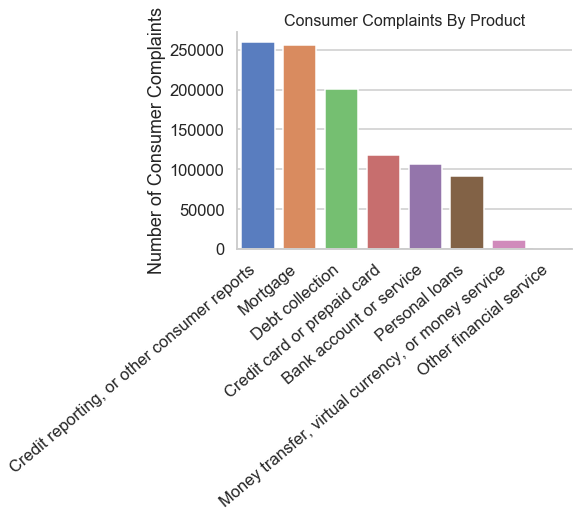

In [13]:
# add the new list of products into the data frame. 
df['Product_new'] = pd.Series(new_list)

# Value counts of the simplified product list 
product_order = pd.Series(new_list).value_counts().index
print('How many complaints per product:')
print(pd.Series(new_list).value_counts())

sns.countplot(data=df, x='Product_new', order = product_order, palette='muted')
plt.xticks(rotation=40, ha="right")
plt.title('Consumer Complaints By Product',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('')
plt.ylabel('Number of Consumer Complaints')
plt.savefig('./../results/product_complaints.png', bbox_inches='tight', dpi = 150)



This reveals that "Credit reporting, or other consumer reports", "mortgage" and "Debt collection" are the three most complained financial products since 2011. And products receiving the least complaints are "Money transfer, virtual currency,or money services" and "Other financial service". 

Here we noted that the credict reporting ranks the first being complained among all products. Let us take a look at this over the years. 

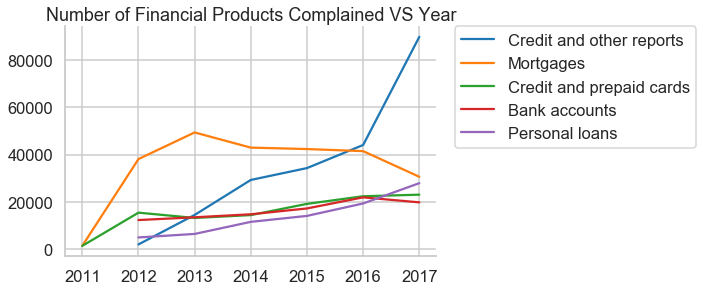

In [14]:
# generate list of products over the years
credit = df.groupby('Product_new')['Year'].value_counts().unstack().reset_index().iloc[2,:][0:-1]
mortgage = df.groupby('Product_new')['Year'].value_counts().unstack().reset_index().iloc[5,:][0:-1]
card = df.groupby('Product_new')['Year'].value_counts().unstack().reset_index().iloc[1,:][0:-1]
bank = df.groupby('Product_new')['Year'].value_counts().unstack().reset_index().iloc[0,:][0:-1]
loans = df.groupby('Product_new')['Year'].value_counts().unstack().reset_index().iloc[7,:][0:-1]
 
credit_years = credit.reset_index()[2][1:]
mortgage_years = mortgage.reset_index()[5][1:]
card_years = card.reset_index()[1][1:]
bank_years = bank.reset_index()[0][1:]
loans_years = loans.reset_index()[7][1:]
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017]

# plot the result
sns.set_style('whitegrid')
plt.figure(figsize=(10,4))
plt.plot(years, credit_years, label='Credit and other reports')
plt.plot(years, mortgage_years, label='Mortgages')
plt.plot(years, card_years, label='Credit and prepaid cards')
plt.plot(years, bank_years, label='Bank accounts')
plt.plot(years, loans_years, label='Personal loans')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(years)
plt.tight_layout()
plt.title('Number of Financial Products Complained VS Year')
sns.despine()



Now this gives insight! We see among the five most complained products we investigated, most held steady amount of complains year after year. The exception is "Credit reporting and other consumer reports". It kept increasing over the years and more than doubled just from 2016 to 2017. 

This dramatic climb could catch attention. Did the financial institutes change anything from 2016 to 2017 in the credit reporting that is causing the backlash from the customers? This remind me of the 2017 Equifax breach and awoke national credit inforation abuse awareness. It is likely that this caused the spike in the increase of credit report complaints. Or possibily the data collection process by Consumer Financial Protection bureau is the origin of the change. The insight from this could help companies to improve their products and government agencies gain evidence for market regulations. 

We are intereted in whether a complaint will be disputed later in this study. It is natural to check how does the new product column respond to the consumer dispute column. And next we take a visual examination on that. 

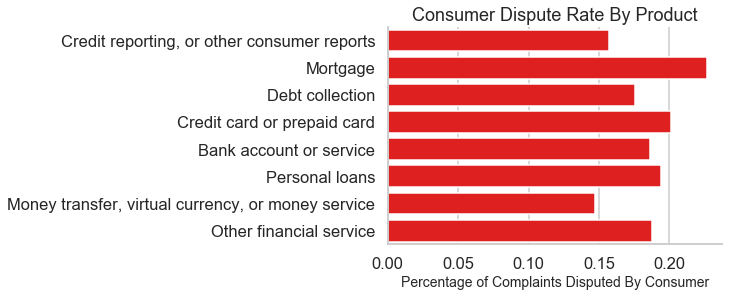

In [15]:
# Percentage of complaints being disputed for the simplified products

df_dispute = df.dropna(axis=0, subset=['Consumer disputed?'])
df_dispute_product = df_dispute.groupby('Product_new')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()

sns.barplot(data=df_dispute_product, y='Product_new', x='Yes',order = product_order, color='red')

#sns.barplot(data=df_dispute, x='Product_new', hue='Consumer disputed?',order = pd.Series(new_list).value_counts().index)

plt.title('Consumer Dispute Rate By Product')
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer',fontsize=14)
plt.ylabel('')
plt.savefig('./../results/dispute_product.png', bbox_inches='tight', dpi = 150)

Here are the observations:  
1. The product that gets the highest dispute rate is mortgage. 
2. Money transfer, virtual currency, or money services is the least disputed product. To be specific, it is 35% less possible for it to be disputed than mortgage. 
3. The rest of the dispute rates range among 15% to 20%. 

More thoughts:  
Why are the complaints toward mortgage tend to get more dispution? Is there a way for companies to respond so that it would satisfy the customers' need better?

<a id='eda'></a>
## Exploratory Data Analysis 

We have had a glance at the financial product consumer complaints data and did some data wrangling on some features. The analysis in the number of complaints over the years gives insight in the customer saticfaction various financial products.   

In this next chapter, we take a deeper dive into the set of datag by doing exploratory data analysis. We will investigate how time, location, companies affect the complaints, what issues are most brought up, and if there is a pattern in whether a complaint would be disputed. 

<a id='mad'></a>
### Analysing complaints by the month and the day of the week
 
Consumer complaints tend to occur all throughout the year. Is there a hot complaint month? In other words, how are the complaints distributed throughout the months since its inception? Let us find out.

![calender](https://media.giphy.com/media/xTiQywlOn0gKyz0l56/giphy.gif "Calender Gif")

Text(0,0.5,'Number of Complaints')

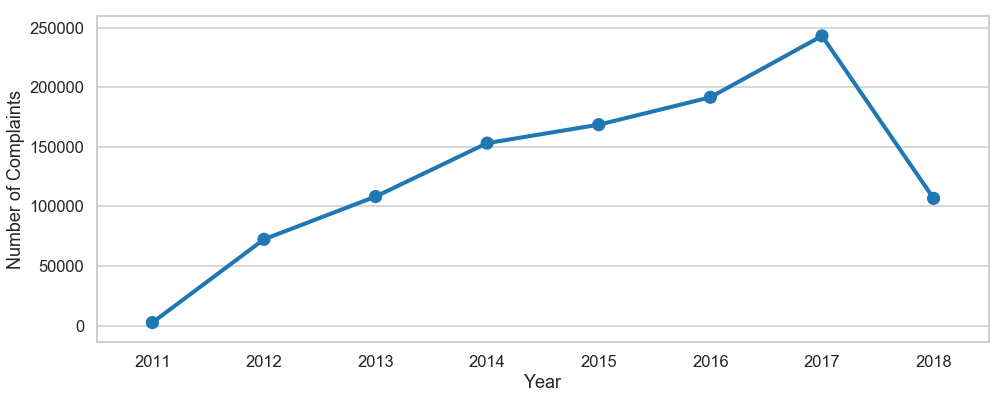

In [16]:
# plot number of complaints over the years
df_year = pd.DataFrame(df['Year'].value_counts().reset_index())
df_year.columns=['Year', 'Complaints']
plt.figure(figsize=(16,6))
sns.pointplot(x='Year', y='Complaints', data=df_year)
plt.ylabel('Number of Complaints')

Looks like the number of complaints consistently increase since the start of the program from 2011. The number in 2018 decreases because the incompletion of the data in 2018 (we are in the early part of 2018 as of this study).  

In [17]:
# set lists of months and days of the week
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [18]:
# add received month column into the data 
df['receive month'] = df['Date received'].apply(lambda x: month_order[x.month-1])

# exclude the year 2011 and 2018 since they include an incomplete year. 
month_df = pd.DataFrame(df[(df['Year']!=2018) & (df['Year']!=2011)]['receive month'].value_counts()).reset_index()
month_df.columns = ['Month', 'Complaints']

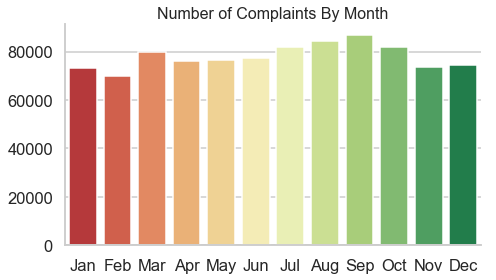

In [19]:
# plot the number of complaints by month of the year
plt.figure(figsize=(7,4))
sns.barplot(x='Month', y='Complaints', data=month_df, order=month_order, palette="RdYlGn")
plt.title('Number of Complaints By Month',fontsize=16)
sns.despine()
plt.xlabel('')
plt.ylabel('')
#plt.xticks(rotation=10,  ha="center")
plt.tight_layout()
plt.savefig('./../results/monthly_complaints.png', bbox_inches='tight', dpi = 150)
sns.set_style('whitegrid')

Looks like the August, September and October are among the months that CFPB receives the most complaints. The cold month when least complaints happen are Februry, Janurary and November. Note that I did not take the year 2011 and 2018 into consideration since not all months are recorded for these years. 



Next I want to find the most complaint months for "Credit reporting and other customer reports" and "Mortgage". These two financial products are top two most complained over the years. 

To do this, the data set was aggregated by month and the products. Then the accurance of each product in each month was counted and normalized by month. Then the products of interest were picked out and transformed into bar plots, as shown below.  

Text(0,0.5,'')

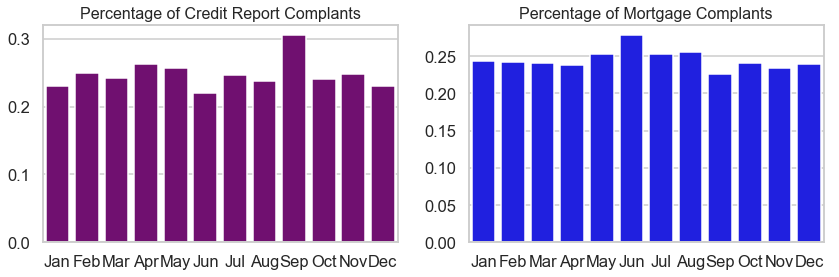

In [20]:
# take the two most complained products: credit reporting and other consumer reports and mortgage, as examples
# plot the percentage of the picked out products VS month of the year
fig, axs = plt.subplots(ncols=2, figsize=(14,4))


df_product_month = df.groupby('receive month')['Product_new'].value_counts(normalize=True).unstack().reset_index()
df_product_month_reports = df_product_month[['receive month', 'Credit reporting, or other consumer reports', 'Mortgage']]
sns.barplot(x='receive month', y='Credit reporting, or other consumer reports', data=df_product_month_reports, order=month_order, color='purple', ax=axs[0])
axs[0].set_title('Percentage of Credit Report Complants',fontsize=16)
axs[0].set_xlabel('')
axs[0].set_ylabel('')
#plt.savefig('./../results/monthly_complaints.png', bbox_inches='tight', dpi = 150)


sns.barplot(x='receive month', y='Mortgage', data=df_product_month_reports, order=month_order, color='blue', ax=axs[1])
axs[1].set_title('Percentage of Mortgage Complants',fontsize=16)
axs[1].set_xlabel('')
axs[1].set_ylabel('')

The plot above on the left (purple) represents the percentage of complaints for "Credit reporting and other consumer reports" for each month. It seems that for most months, credit report complaints consist around 23% of all product complaints. However, it is worth noticing that more than 30% of the complaints are towards credit reports in September! This is significant, statistically speaking, as shown in the $\chi ^2$ test below. 

In the meantime, it is shown in the right plot (blue) that the month that has highest rate of mortgage complaint is June. 

It would give insight to preparing the companies to reply the consumer complaints. For example, it would make sense to arrange more staff to handle credit report complaints in September and mortgage in the summer months. It could also be meaningful to discover the underlying reasons for the phenomenon found here. What is special about September that causes the credit report complaints to spike? Is summer the hottest time for housing market and is that the reason for the increase in the mortgage complaints?  



In [21]:
df_product_dummy = pd.get_dummies(data=df["Product_new"], drop_first=False)
cont_table = pd.crosstab(index=df_product_dummy['Credit reporting, or other consumer reports'], columns=df['receive month'])
chi2, pval, _, _ = stats.chi2_contingency(cont_table)
print("Chi-squared test statistic: {}".format(chi2))
print("p-value: {}".format(pval))
#df_product_dummy

Chi-squared test statistic: 2368.5478544865946
p-value: 0.0


Chi-squared test statistic: 91.54767309918327
p-value: 8.288005735000199e-15


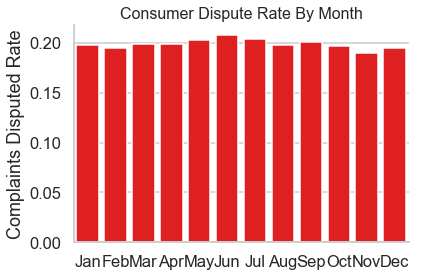

In [22]:
# Check the dispute rate for each month
df_dispute_avail = df[(df['Year']!=2017) & (df['Year']!=2018)].dropna(axis=0, subset=['Consumer disputed?'])
df_dispute_month = df_dispute_avail.groupby('receive month')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
#print(df_dispute_month)
sns.barplot(x=df_dispute_month['receive month'], y=df_dispute_month['Yes'], order=month_order, color="red")
plt.ylabel('Complaint ')
plt.title('Consumer Dispute Rate By Month',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('')
plt.ylabel('Complaints Disputed Rate')
plt.savefig('./../results/month_dispute.png', bbox_inches='tight', dpi = 150)

# check if the change is statistically significant
cont_table = pd.crosstab(index=df_dispute_avail['Consumer disputed?'], columns=df_dispute_avail['receive month'])
chi2, pval, _, _ = stats.chi2_contingency(cont_table)
print("Chi-squared test statistic: {}".format(chi2))
print("p-value: {}".format(pval))

The plot above shows the how much complaint was disputed for each month. It seems that the dispute rate stays more or less stable around the year with June going slightly higher than the rest. We have studied the dispute rate for each product and know that mortgage complaints tend to get more dispute. The mortgage monthly result shows that it is most complained in June. This could be the reason causing the small dispute rate bump in June.  

Now we have a good understanding on how the complaints change over the month of the years. It is time to move on and take a look at the day of the week. 

In [23]:
# consumer complaints by day of the week 

df['receive weekday'] = df['Date received'].apply(lambda x: day_order[x.weekday()])

df_dispute_avail = df.dropna(axis=0, subset=['Consumer disputed?'])
weekday_df = pd.DataFrame(df['receive weekday'].value_counts()).reset_index()
weekday_df.columns = ['WeekDate', 'Complaints']

Text(0,0.5,'')

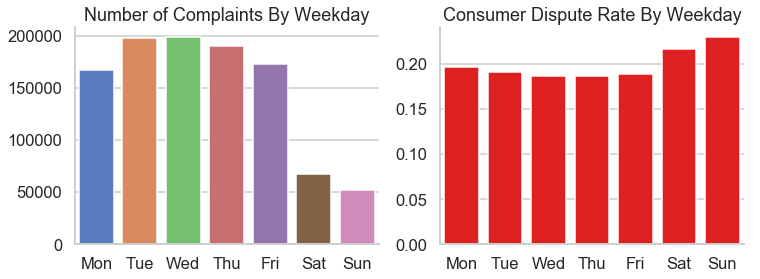

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.set_style('whitegrid')
sns.despine()

sns.barplot(x='WeekDate', y='Complaints', data=weekday_df, order=day_order, palette='muted',ax=axs[0])
axs[0].set_title('Number of Complaints By Weekday')
axs[0].set_xlabel('')
axs[0].set_ylabel('')
#plt.savefig('./../results/weekly_complaints.png', bbox_inches='tight', dpi = 150)

df_dispute_weekday = df_dispute_avail.groupby('receive weekday')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
#print(df_dispute_weekday)
sns.barplot(x='receive weekday', y='Yes', data = df_dispute_weekday, order=day_order, color='red', ax=axs[1])
axs[1].set_ylabel('Complaint disputed')
axs[1].set_title('Consumer Dispute Rate By Weekday')
axs[1].set_xlabel('')
axs[1].set_ylabel('')

#plt.savefig('./../results/weekday_dispute.png', bbox_inches='tight', dpi = 150)



The plots tell us:
1. CFPB receives most complaints on Tuesday and Wednesday.  
2. Only about a quarter of complaints are received on the weekend.  
3. There is about 15% higher chance of the complaint being disputed if it was received on the weekend. 

<a id='sccc'></a>
### State comparison of consumer complaints
After the study of the time effect on the consumer complaints, I move onto the location analysis.

To do this, the column "State" was used to examine the rest of the data. "State" contains US state codes that is usually a two letter short. To make the plot more readable for users, I found code and state name data from https://www.census.gov/geo/reference/ansi_statetables.html. 

The number of complaints and the most complaint financial product were calculated for each state. The result, combined with the state name/code data was presented in an interactive plot using the tool plotly offers. 

In [25]:
# Found code and state name data from https://www.census.gov/geo/reference/ansi_statetables.html
# change the code and state name into dictionary for later use.
state_code= pd.read_csv('./../us states code.csv')
code = state_code['STATE|STUSAB|STATE_NAME|STATENS'].apply(lambda x : x.split('|')[1])
state_name = state_code['STATE|STUSAB|STATE_NAME|STATENS'].apply(lambda x : x.split('|')[2])
state_dict = dict(zip(code, state_name))
state_dict['AA'] = 'American Armed Forces'
state_dict['AE'] = 'American Armed Forces'
state_dict['AP'] = 'American Armed Forces'
state_dict['FM'] = 'Micronesia'
state_dict['MH'] = 'Marshall Islands'
state_dict['PW'] = 'Palau'
state_dict['UNITED STATES MINOR OUTLYING ISLANDS'] = 'UNITED STATES MINOR OUTLYING ISLANDS'

In [26]:
# build a new data frame of the consumer complaints count and products count for each state. 
state_product = df.groupby('State')['Product_new'].value_counts().unstack().reset_index()
state_count = pd.DataFrame(df['State'].value_counts()).reset_index()
state_count.columns = ['State','Count']
state = state_product.merge(state_count, on = 'State')
product_list = state_product.columns[1:]

# find the most complained product for each state. Find the full name of the each state code. 
# Combine the information into one text column that will be used for interactive plotting next.  
state_max_product = []
state_max_product_count = []
for index, row in state_product.iterrows():
    max_product_count = 0
    state_name_i = state_dict[row['State']]
    for i in product_list:
        if row[i] > max_product_count:
            max_product_count = row[i]
            product_name = i
    state_max_product.append(state_name_i+"<br>"+ product_name+": "+str(max_product_count))
state['state_max_product'] = state_max_product 

state.head(5)

,State,Bank account or service,Credit card or prepaid card,"Credit reporting, or other consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Mortgage,Other financial service,Personal loans,Count,state_max_product
0,AA,5.0,3.0,2.0,2.0,NaN,7.0,NaN,3.0,22,American Armed Forces<br>Mortgage: 7.0
1,AE,34.0,42.0,106.0,68.0,11.0,99.0,NaN,61.0,421,"American Armed Forces<br>Credit reporting, or ..."
2,AK,115.0,183.0,285.0,263.0,25.0,220.0,1.0,103.0,1195,"Alaska<br>Credit reporting, or other consumer ..."
3,AL,988.0,966.0,3698.0,2581.0,75.0,2031.0,14.0,1304.0,11657,"Alabama<br>Credit reporting, or other consumer..."
4,AP,15.0,42.0,74.0,64.0,5.0,53.0,NaN,31.0,284,"American Armed Forces<br>Credit reporting, or ..."


In [27]:
plotly_data = dict(type='choropleth',
            colorscale = 'Jet',
            locations = state['State'],
            z = state['Count'],
            locationmode = 'USA-states',
            text = state['state_max_product'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Millions USD"}
            ) 

layout = dict(title = 'Financial Products Consumer Complaints by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

In [28]:
choromap = go.Figure(data = [plotly_data],layout = layout)
iplot(choromap)

This interactive plot tells us:  
1. CFPB receives the most complaints from California, Florida, and Texas. 
2. Mortgage tends to be the most complaint product for states with more expensive housings.
3. After referring to the population of the states, Florida stands out. The complaint number per capita in Florida is much higher than the rest of the states. What is causing this? Should financial companies and the state of Florida take a deeper look into what is happening here?

<a id='iwc'></a>
### Issues Wordcloud

Now let's take a look at what are the most appeared words in the complained issues. Since there are more than 150 unique issues and some of them might be similar, it makes sense to make a word cloud to visually find it out. 

In [29]:
top_issue = list(pd.DataFrame(df['Issue'].value_counts()[0:30]).index)

df_top_issue = df[df['Issue'].isin(top_issue)]

In [30]:
df_top_issue['Issue'].value_counts().head(5)

Loan modification,collection,foreclosure    112313
Incorrect information on credit report      102687
Loan servicing, payments, escrow account     77337
Incorrect information on your report         66044
Cont'd attempts collect debt not owed        60703
Name: Issue, dtype: int64

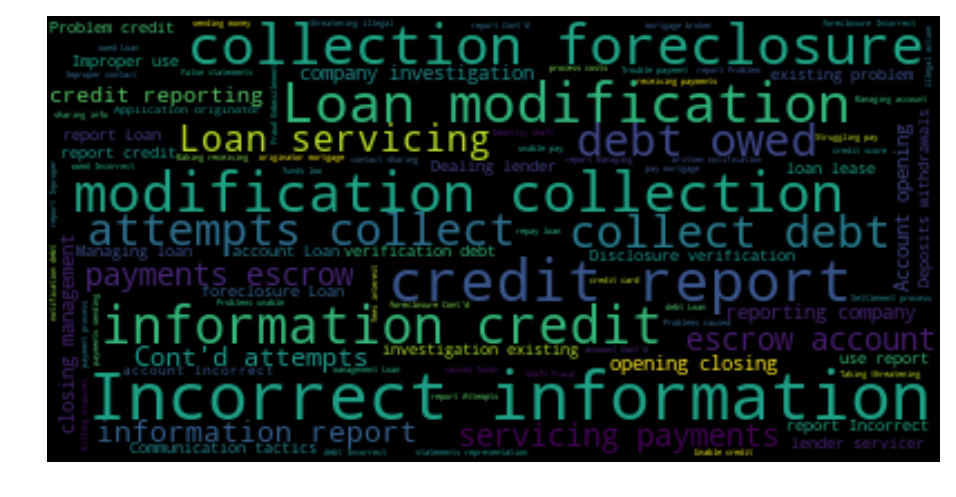

In [31]:
# Word cloud from issue

all_tags = []
for iter_row, row in df.iterrows():
    my_tags = row['Issue'].split(',')
    for tag in my_tags:
        all_tags.append(tag)


#Read the whole text.
text = ' '.join(all_tags)

text
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40).generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./../results/issue_wordcloud.png',bbox_inches='tight', dpi = 150)
plt.show()

The word cloud plot gives a direct impression of what appear to be most mentioned in the "Issue" column. "Incorrect information", "credit report", "collection" and "roreclosure" are among the top issues being mentioned in the data set. This agrees with the product feature in the data set. 

The word cloud also gives us some insight in some informative issues, such as "closing management", "payments escrow", and "improper use". It gives practical reasons why the financial products were complained. 

<a id='cpr'></a>
### Companies and responses

Is there a correlation between company and the dispute rate? How about the response by companies? 

First we examine the companies, since there are more than 4822 unique companies in the data, I will only analyze the dispute rate for the top ten most appeared companies. 

In [32]:
df['Company'].nunique()

4822

In [33]:
top_company = list(pd.DataFrame(df.Company.value_counts()[0:10]).index)
df_top_comp = df[df['Company'].isin(top_company)]

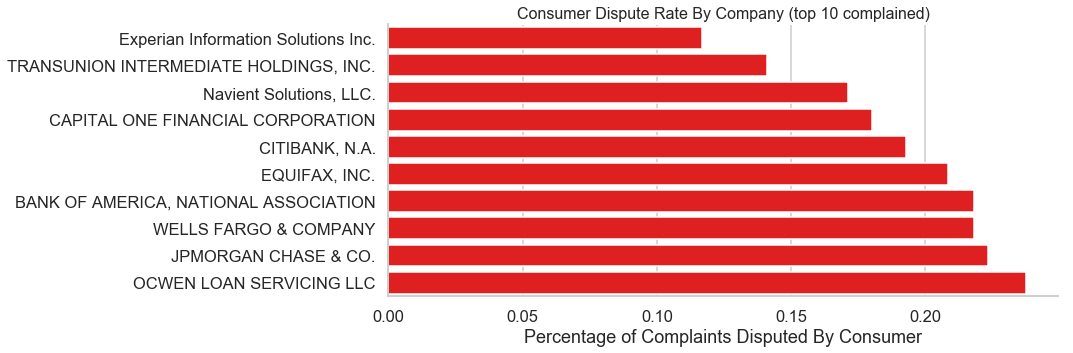

In [34]:
#most appeared companies VS disputed?

df_comp = df_top_comp.groupby('Company')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
plt.figure(figsize=(12,5))
sns.barplot(y='Company', x='Yes', data = df_comp.sort_values('Yes'), color='red')
plt.title('Consumer Dispute Rate By Company (top 10 complained)',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('')
plt.savefig('./../results/company_dispute.png', bbox_inches='tight', dpi = 150)


There is quite a difference! Among the top ten most appeared companies, OCWEN LOAN SERVICING LLC has the highest disputed rate. That rate is double the dispute rate of the best performed company examined here: Experian Information Solutions Inc. 

OCWEN LOAN SERVICING LLC is a leading mortgage service company in the US. We already know mortgage is the most disputed product in the data. This could explain why the company with the sole product is more prone to the consumer dispute.  

Next we take a look at how the company response to the complaints lead to different outcome of dispute rate. There are two features relevant here: "Company response to consumer" and " Company public response". We will examine both. 

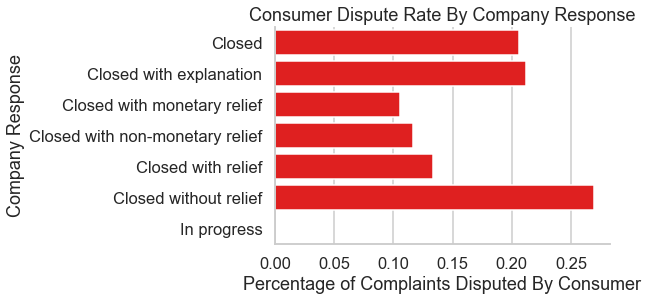

In [35]:
#check how many complaints were disputed for company response to consumer. 
df_response = df.dropna(axis=0, subset=['Consumer disputed?']).groupby('Company response to consumer')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
df_response.drop([7], axis=0, inplace=True)
#print(df_response)#.dropna(subset=['Yes'], inplace=True)
sns.barplot(y='Company response to consumer', x='Yes', data = df_response, color='red')
plt.xlabel('Complaint disputed')
plt.title('Consumer Dispute Rate By Company Response')
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('Company Response')
plt.savefig('./../results/company_response_dispute.png', bbox_inches='tight', dpi = 150)

The plot above indicates how the company response to consumer affect the possibility of the complaint being disputed. When the company responses "Closed without relief", there is a more than 26% chance that the complaint will be disputed. In the meantime, the response of closed with monetary relief receives half of the chance of dispution. This makes perfect sense: if a complaint was closed without relief, consumer has more reasons to ask for justification for themselves.

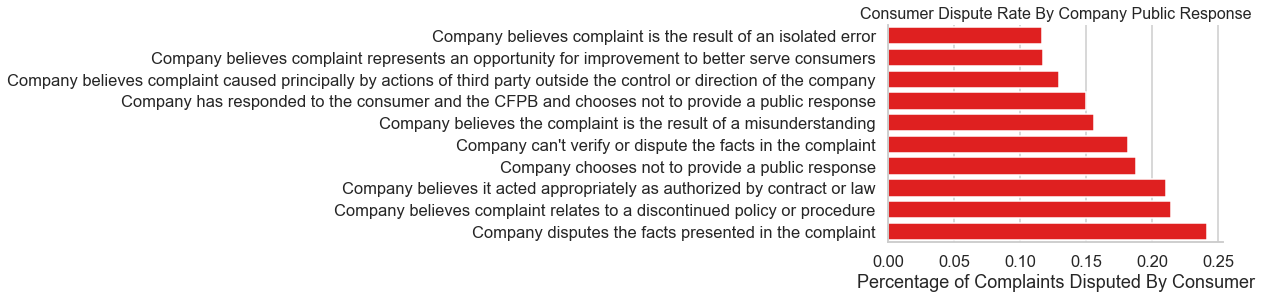

In [36]:
# disputed rate for public company responses
df_company_response_dispute = df.dropna(axis=0, subset=['Consumer disputed?'])
df_company_response_dispute_rate=df_company_response_dispute.groupby('Company public response')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
# set value to 0 instead of NaN for one input.
sns.barplot(y='Company public response', x='Yes', data = df_company_response_dispute_rate.sort_values('Yes'), color='red')
plt.title('Consumer Dispute Rate By Company Public Response',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('')
plt.savefig('./../results/public_company_response_dispute.png', bbox_inches='tight', dpi = 150)

The plot above indicates how the public response by company makes a difference in the dispute rate. Again, the dispute rate ranges from 12% - 25%. 
1. The most disputed public response in this case was when company disputes facts presented in the complaints. 
2. The least dispute public responses are "isolated error" and "represents opportunity for improvement". 
3. It is worth noting that the responses of "discontinued policy or procedure" or "acts appropriately" do not satisfy the consumers since they are among the highest disputed responses.

Companies could find very useful information in how to respond to consumers for their highest satisfaction. While avoiding consumer dispute is not the ultimate mission of the financial companies, this explorative data analysis reveals insights in what consumers like to hear when they file complaints. It could help shape the customer service policy in the financial companies to maximize consumer satisfaction. 

<a id='ml'></a>
## Machine Learning: Predict consumer dispute.

Can we use machine learning models to predict whether a company response of a complaint will be disputed based on the data set? If the top contributions to disputes can be found, companies can take proactive means to lessen the dispute rate. This adds another perspective into promote customer service and satisfaction.


<a id='fe'></a>
### Feature Engineering

The data set contains the feature of zip code. It is tricky to treat zip code in machine learning. They are not exactly numerical variable and there are so many zip codes, it takes considerable memory and computation to treat it as a categorical variable. In this study, I found rural urban codes data from https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/. Using this data, zip codes could be converted to rurality of the location and it could give us information of whether it will affect the dispute rate.

In [37]:
# import rural urban codes data
ruraldata = pd.read_excel('./../ruralurbancodes2013.xls', sheetname='Rural-urban Continuum Code 2013')
ruraldata.head()

/home/punted/.local/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning:

The `sheetname` keyword is deprecated, use `sheet_name` instead



,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,1001,AL,Autauga County,54571,2,"Metro - Counties in metro areas of 250,000 to ..."
1,1003,AL,Baldwin County,182265,3,Metro - Counties in metro areas of fewer than ...
2,1005,AL,Barbour County,27457,6,"Nonmetro - Urban population of 2,500 to 19,999..."
3,1007,AL,Bibb County,22915,1,Metro - Counties in metro areas of 1 million p...
4,1009,AL,Blount County,57322,1,Metro - Counties in metro areas of 1 million p...


In [38]:
# find data convert FIPS to zip code to use with consumer complaints data
zipfips = pd.read_csv('./../ZIP-COUNTY-FIPS_2013-12.csv')
zipfips.head()

,ZIP,COUNTYNAME,STATE,STCOUNTYFP,CLASSFP
0,36006,Autauga County,AL,1001,H1
1,36003,Autauga County,AL,1001,H1
2,36067,Autauga County,AL,1001,H1
3,36066,Autauga County,AL,1001,H1
4,36703,Autauga County,AL,1001,H1


In [39]:
# merge the zipcode to FIPS data with the FIPS data to rural level data. 
# so that we can use it to merge with the zipcode to rural area data
zip_to_rural = zipfips.merge(ruraldata, how='left', left_on='STCOUNTYFP', right_on='FIPS')[['ZIP','RUCC_2013']]

In [40]:
# Use the the zip code column of the original data frame, and the above zip to rurality data frame to engineer a new column
# representing how rural the call origin is .
rural = []

df_fillna = df.fillna(10)

for index, row in df_fillna.iterrows():
    
    if row['ZIP code']==0:
        rural.append(10)
    else:
        try: 
            rural.append(zip_to_rural.loc[zip_to_rural['ZIP']== int(row['ZIP code'])]['RUCC_2013'].values[0])
        except IndexError:
            rural.append(10)
        except ValueError: 
            try:
                xlower = int(row['ZIP code'][:-2])*100
                rural_code = zip_to_rural.loc[zip_to_rural['ZIP'].isin( np.arange(xlower, xlower+100))]['RUCC_2013'].value_counts().index.values[0]
                rural.append(rural_code)
            except IndexError:
                rural.append(10)  
            except ValueError:
                rural.append(10)
    

In [41]:
# Add the rurality code to the orignal data frame
df['RuralityCode'] = rural

Chi-squared test statistic: 157.21122476606365
p-value: 2.8182431884754376e-29


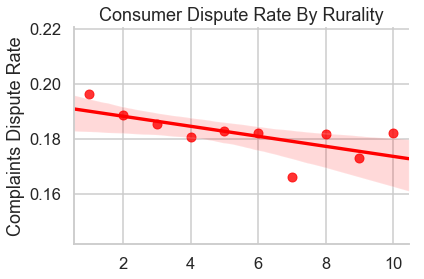

In [42]:
# Check the dispute rate for each month
df_dispute_avail = df.dropna(axis=0, subset=['Consumer disputed?'])
df_dispute_rual = df_dispute_avail.groupby('RuralityCode')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
#print(df_dispute_rual)
sns.regplot(x=df_dispute_rual['RuralityCode'], y=df_dispute_rual['Yes'], color="red")
plt.ylabel('Complaint ')
plt.title('Consumer Dispute Rate By Rurality')
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('')
plt.ylabel('Complaints Dispute Rate')
plt.savefig('./../results/month_dispute.png', bbox_inches='tight', dpi = 150)

# check if the change is statistically significant
cont_table = pd.crosstab(index=df_dispute_avail['Consumer disputed?'], columns=df_dispute_avail['RuralityCode'])
chi2, pval, _, _ = stats.chi2_contingency(cont_table)
print("Chi-squared test statistic: {}".format(chi2))
print("p-value: {}".format(pval))

Wow, we see a linear trend between rurality of the location and the dispute rate of the complaint. The more rural the location is (larger x axis), the less chance the complaint will be disputed. I am adding this engineered feature into the data for machine learning. 

Next check the consumer dispute VS consumer narrative length. Add the consumer narrative length into the feature list. 

/home/punted/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



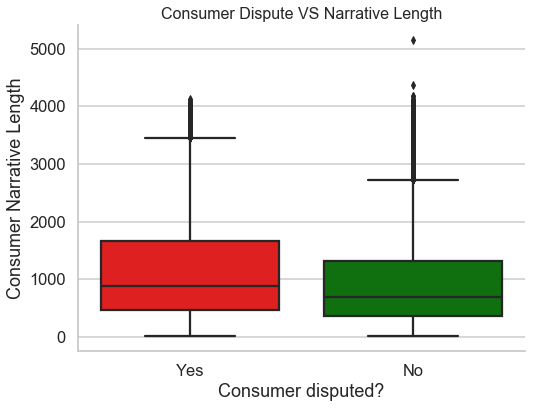

In [43]:
df_narative = df.dropna(axis=0, subset=['Consumer complaint narrative','Consumer disputed?'])
df_narative['NarativeLength'] = [len(nara) for nara in df_narative['Consumer complaint narrative']]
# length of the narrative VS consumer disputed?
plt.figure(figsize=(8,6))
sns.boxplot(data=df_narative, y='NarativeLength', x='Consumer disputed?', order=['Yes', 'No'],palette=['red', 'green'])

plt.title('Consumer Dispute VS Narrative Length',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.ylabel('Consumer Narrative Length')
plt.xlabel('Consumer disputed?')
plt.savefig('./../results/narrativelength_dispute.png', bbox_inches='tight', dpi = 150)


<a id='dpsp'></a>
### Feature Selection

In [44]:
# DF before feature selection
df_narative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164126 entries, 1 to 1045878
Data columns (total 26 columns):
index                           164126 non-null int64
Unnamed: 0                      164126 non-null int64
Date received                   164126 non-null datetime64[ns]
Product                         164126 non-null object
Sub-product                     111943 non-null object
Issue                           164126 non-null object
Sub-issue                       83111 non-null object
Consumer complaint narrative    164126 non-null object
Company public response         78133 non-null object
Company                         164126 non-null object
State                           163680 non-null object
ZIP code                        162880 non-null object
Tags                            27007 non-null object
Consumer consent provided?      164126 non-null object
Submitted via                   164126 non-null object
Date sent to company            164126 non-null datetime64[n

In [45]:
df_narative_sample = df_narative.sample(frac=0.01, random_state=41)
df_narative_sample['Consumer disputed?'].value_counts()

No     1285
Yes     356
Name: Consumer disputed?, dtype: int64

In [46]:
# drop irrelevant columns and the consumer narrative columns (for NLP)
df_dispute_short = df_narative_sample.drop(['Sub-issue', 'Consumer consent provided?', 'ZIP code','Date received', 'Date sent to company', 'Consumer complaint narrative','Complaint ID'],axis=1)

In [47]:
# fill nan with 0
df_dispute_short_filled = df_dispute_short.fillna(0)

In [48]:
# dummy the columns
df_dummies = pd.get_dummies(data=df_dispute_short_filled.drop(['Consumer disputed?', 'NarativeLength'], axis=1), drop_first=True)

In [49]:
# DF after dummies
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 420131 to 635076
Columns: 600 entries, index to receive weekday_Wed
dtypes: float64(1), int64(3), uint8(596)
memory usage: 1019.2 KB


#### Feature selection for categorical columns using $\chi^2$ test. 
Next, we go through all the dummied categorical variables and do the $\chi^2$ test with the consumer dispute column. The purpose is to filter out attributes that statistically insignificant. This will simplify our model.

In [50]:
# feature selection
# all columns are treated as categorical

p_vals_cate = pd.DataFrame(columns=['Attribute', 'P_value'])
categoric = df_dummies.columns
p_large = []

for col in categoric:
    # Creating cross tabulated data for Chi-square test
    counttable = pd.crosstab(df_dummies[col], df_narative['Consumer disputed?'])
    chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
    p_vals_cate = p_vals_cate.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    if p>0.01:
         p_large.append(col)
    
# Printing p-values of Chi-squared tests, sorted by p-values
print('P-values from Chi-Squared Contingency Tests')
print(p_vals_cate.sort_values('P_value', ascending=True).head(10))

print('info of df before deleting insignificant attributes:')
print(df_dummies.info())

df_dummies_sig  = df_dummies.drop(p_large, axis=1)

print('info of df after:')
print(df_dummies_sig.info())

# add length of narrative back

df_dummies_sig['NarativeLength'] = df_dispute_short_filled['NarativeLength']

P-values from Chi-Squared Contingency Tests
                                             Attribute   P_value
571  Company response to consumer_Closed with expla...  0.000001
573  Company response to consumer_Closed with non-m...  0.000013
252                              Company_EQUIFAX, INC.  0.000192
2                                                 Year  0.001809
587                                  receive month_Jul  0.005267
539                                           State_MN  0.006484
179                    Company_BYL Collection Services  0.007178
92                                Issue_Getting a loan  0.007178
514                                           State_AK  0.007178
14             Sub-product_(CD) Certificate of deposit  0.007178
info of df before deleting insignificant attributes:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 420131 to 635076
Columns: 600 entries, index to receive weekday_Wed
dtypes: float64(1), int64(3), uint8(596)
memory usage: 1

Then the significant columns will be tested for correlation so that highly correlated columns will be deleted. 

In [51]:
# Create correlation matrix
corr_matrix = df_dummies_sig.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
df_dummies_choose = df_dummies_sig.drop(to_drop, axis=1)


print('info of df after correlation feature test:')
print(df_dummies_choose.info())


info of df after correlation feature test:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 420131 to 635076
Data columns (total 14 columns):
Year                                                            1641 non-null int64
Sub-product_(CD) Certificate of deposit                         1641 non-null uint8
Issue_Getting a loan                                            1641 non-null uint8
Company_BYL Collection Services                                 1641 non-null uint8
Company_EQUIFAX, INC.                                           1641 non-null uint8
Company_HSBC NORTH AMERICA HOLDINGS INC.                        1641 non-null uint8
Company_SCOTTRADE BANK                                          1641 non-null uint8
State_AK                                                        1641 non-null uint8
State_MN                                                        1641 non-null uint8
State_NJ                                                        1641 non-null uint8
Com

After feature selection, the original data containing 3421 columns reduced to 261 columns. The features prepared for the mechine learning step are statistically significant and independent from each other. This step promotes the efficiency of classifying models.  

<a id='nlp'></a>
### Natural Language Processing

#### NLP steps:
    1. Remove all punctuation  
    2. Remove all stopwords  
    3. Returns a list of the cleaned text  
    4. Transform into TFIDF format

In [52]:
# use this if stop words and other tools are not downloaded already
#nltk.download_shell()

In [53]:
import string
from nltk.corpus import stopwords


def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [54]:
# try the text process on one narrative
df_narative['Consumer complaint narrative'].head(1).apply(text_process)

1    [outdated, information, credit, report, previo...
Name: Consumer complaint narrative, dtype: object

In [55]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process, ngram_range=(2,3))

bow_transformer.fit(df_narative_sample['Consumer complaint narrative'])

# Print total number of vocab words.fit(df_narative['Consumer complaint narrative'])

print(len(bow_transformer.vocabulary_))

narrative_bow = bow_transformer.transform(df_narative_sample['Consumer complaint narrative'])

11533


Next, investigate the bag of words transformed from teh consumer complaint narrative. The ECDF plot is shown below. It helps to filter out words that appear too few times and too many times in the narratives to make a difference.  

Use the df_min and df_max found from the ECDF to transform the bag of words again.  

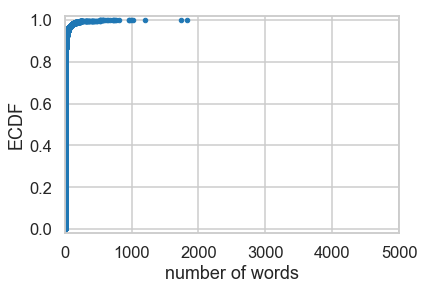

In [56]:
sum_of_words_long = narrative_bow.sum(axis=0)
sum_of_words = sum_of_words_long.flatten().tolist()[0]



def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    #data_sorted = np.sort(data)
    #total = data.sum()
    #y_matrix = np.cumsum(data_sorted)/total
    #y = np.squeeze(np.asarray(y_matrix))
    y = np.arange(1, n+1)/n
    return x, y


x_cdf, y_cdf = ecdf(sum_of_words)



    
# Generate plot
_ = plt.plot(x_cdf, y_cdf, marker='.', linestyle='none')

# Make the margins nice
_ = plt.margins(0.02)

# Label the axes
_ = plt.xlabel('number of words')
_ = plt.ylabel('ECDF')
_ = plt.xlim([0,5000])


plt.show()

In [57]:
# Use the df_min and df_max found from ecdf to re bag of words
bow_transformer = CountVectorizer(analyzer=text_process, min_df=30, max_df=10000, ngram_range=(2,3))

bow_transformer.fit(df_narative_sample['Consumer complaint narrative'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

narrative_bow = bow_transformer.transform(df_narative_sample['Consumer complaint narrative'])

677


In [58]:
#transform text to TFIDF format

tfidf_transformer = TfidfTransformer()


narrative_tfidf = tfidf_transformer.fit_transform(narrative_bow)
print(narrative_tfidf.shape)

(1641, 677)


Now we have transformed the consumer narrative to vectorized bag of words, and converted it into the term frequency–inverse document frequency (tfidf). TFIDF makes the word more important if the word appear in less documents in the collection or corpus.

#### Classifier using NLP only and Naive Bayes model 

As a quick check, we use the TFIDF matrix generated after NLP and Naive Bayes classifier to predict the consumer dispute. First train-test split and random under sampling. 

Next, the I use selectKbest for the feature selection of the tfidf matrix. The function from the sklearn module selects features according to the k highest scores. To choose the best k, the code below generates a Naive Bayes score plot with different choices of k. It seems that the classification score increases when k increases from 2000. The score peaks when the number of features hits 3500 then starts to decrease. 

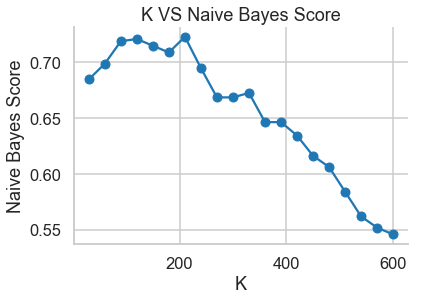

In [59]:
# feature selection k best
rus = RandomUnderSampler(random_state=41)

krange = np.arange(1,21)*30
krange

# define the features and the target 
target_map = {'Yes': 1, 'No':0}

X1 = narrative_tfidf
y1 = df_narative_sample['Consumer disputed?'].map(target_map)
X, y = rus.fit_sample(X1, y1)
msg_train, msg_test, label_train, label_test = train_test_split(X, y, test_size=0.3, random_state=41)

# choose k for feature selection
score_k =[]
for i in krange:
    # kbest feature selection)
    skb = SelectKBest(k=i)
    msg_new = skb.fit_transform(msg_train, label_train)
    
    # run naive bayes 
    mnb = MultinomialNB()
    param_grid = {"alpha": [ 0.01, 0.1, 1, 5, 50]}
    grid_mnb = GridSearchCV(mnb, param_grid=param_grid, cv=5)
    grid_mnb.fit(msg_new,label_train)

    # print and record the best score from the model
    #print('Best Score:', grid_mnb.best_score_)

    score_k.append(grid_mnb.best_score_)
#msg_train, msg_test, label_train, label_test = train_test_split(X, y , test_size=0.3)

sns.set_style('whitegrid')
plt.plot(krange,score_k, 'o-')
plt.title('K VS Naive Bayes Score')
plt.xlabel('K')
plt.ylabel('Naive Bayes Score')
sns.despine()

Here k=100 is chosen from the above plot. 

In [60]:
X1 = narrative_tfidf
y1 = df_narative_sample['Consumer disputed?'].map(target_map)

skb = SelectKBest(k=100)
X_new = skb.fit_transform(X1, y1)
print(X_new.shape)

X, y = rus.fit_sample(X_new, y1)
msg_train, msg_test, label_train, label_test = train_test_split(X, y , test_size=0.3, random_state=41)

(1641, 100)


In [61]:
#start a grid search for Naive Bayes classifier
mnb = MultinomialNB()
param_grid = {"alpha": [ 0.01, 0.1, 1, 5, 50],
              
              }

grid_mnb = GridSearchCV(mnb, param_grid=param_grid, cv=5)
grid_mnb.fit(msg_train,label_train)

# Printing the best score from the model
print('Best Score:', grid_mnb.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_mnb.best_params_
print('Best Parameters:', best_params)

Best Score: 0.6184738955823293
Best Parameters: {'alpha': 0.01}


In [62]:
#initiate a instance for classifier
mnb = MultinomialNB(**best_params)

# Fit the classifier to the training data
mnb.fit(msg_train,label_train)

# Predict the labels of the test data: y_pred
y_pred = mnb.predict(msg_test)

scores_mnb_train = cross_val_score(mnb, msg_train,label_train, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_mnb_train.mean(), 
                                                                                 scores_mnb_train.std()*2))
scores_mnb_test = cross_val_score(mnb, msg_test, label_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_mnb_test.mean(), 
                                                                                 scores_mnb_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(label_test, y_pred))
print('Classification report on the test data:')
print(classification_report(label_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.61853(+/- 0.03)
Cross Validation Accuracy Scores - Test Set: 0.57487(+/- 0.06)
Confusion matrix on the test data:
[[80 13]
 [65 56]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.55      0.86      0.67        93
          1       0.81      0.46      0.59       121

avg / total       0.70      0.64      0.63       214



The classifying of consumer dispute with NLP on consumer narratives only gives the accuracy score of 0.58. 

<a id='pcd'></a>
### Predict consumer dispute

Now we combine the features from NLP and the rest of the data after feature selection together. We will test several machine learning models using the combined data and check if the classifying has a higher accuracy score. 

#### Combine and split

In [63]:
# combine NLP and other features

df_dummies_sparse = hstack([X_new,df_dummies_choose])

# Use random under sampler to make sure data for classifying has even classes. 

target_map = {'Yes': 1, 'No':0}

rus = RandomUnderSampler(random_state=41)

X1 = df_dummies_sparse
y1 = df_narative_sample['Consumer disputed?'].map(target_map)
#X, y = rus.fit_sample(X1,y1)

# train test split
#msg_train, msg_test, label_train, label_test = train_test_split(X1, y1, test_size=0.3,random_state=41)



In [64]:
# record feature names
col1 = df_dummies_choose.columns.values.tolist()


col2 = bow_transformer.get_feature_names()
#np.col2.shape
#col2[skb.get_support(indices=True)]

# mask the col2 list with the k best feature selection result
col2_new = list(compress(col2, skb.get_support()))

col_names= col2_new + col1

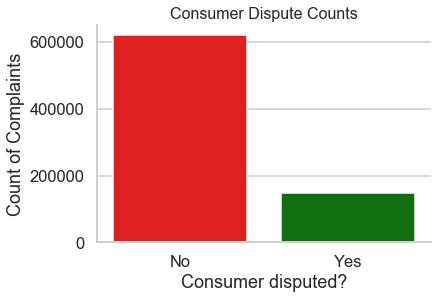

In [65]:
#check how many complaints were disputed. 
sns.countplot(df['Consumer disputed?'], palette=['red','green'])
plt.title('Consumer Dispute Counts',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.ylabel('Count of Complaints')
plt.savefig('./../results/complaint_dispute.png', bbox_inches='tight', dpi = 150)

The combined matrix then undergo train test split and random under sampling. 

In [66]:
# Use random under sampler to make sure data for classifying has even classes. 

df_dummies_sparse = hstack([X_new,df_dummies_choose])

target_map = {'Yes': 1, 'No':0}

#rus = RandomUnderSampler(random_state=41)

X1 = df_dummies_sparse
y1 = df_narative_sample['Consumer disputed?'].map(target_map)
#X, y = rus.fit_sample(X1,y1)

# train test split
msg_train_init, msg_test, label_train_init, label_test = train_test_split(X1, y1, test_size=0.3)

print("Size of training X before over-sampling", msg_train_init.shape)

sm = SMOTE(random_state=41)
msg_train, label_train = sm.fit_sample(msg_train_init, label_train_init)

print("Size of training X after over-sampling", msg_train.shape)


Size of training X before over-sampling (1148, 114)
Size of training X after over-sampling (1776, 114)


In [67]:
df_dummies_choose.columns

Index(['Year', 'Sub-product_(CD) Certificate of deposit',
       'Issue_Getting a loan', 'Company_BYL Collection Services',
       'Company_EQUIFAX, INC.', 'Company_HSBC NORTH AMERICA HOLDINGS INC.',
       'Company_SCOTTRADE BANK', 'State_AK', 'State_MN', 'State_NJ',
       'Company response to consumer_Closed with explanation',
       'Company response to consumer_Closed with non-monetary relief',
       'receive month_Jul', 'NarativeLength'],
      dtype='object')

With the data prepared, we will proceed to test with several classification models. I will find the accuracy score using naive bayes, random forest classifier, logistic regression, and AdaBoost classifier. For each model, the cross validated grid search will be called find the best parameters. Then the found parameters are fed back into the model for prediction of the test data.  


#### Naive Bayes

In [68]:
#start a grid search for Naive Bayes classifier
mnb = MultinomialNB()
param_grid = {"alpha": [ 0.0001, 0.001, 0.01, 1, 5, 50],
              
              }

grid_mnb = GridSearchCV(mnb, param_grid=param_grid, cv=5)
grid_mnb.fit(msg_train,label_train)

# Printing the best score from the model
print('Best Score:', grid_mnb.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_mnb.best_params_
print('Best Parameters:', best_params)

Best Score: 0.5731981981981982
Best Parameters: {'alpha': 0.0001}


In [69]:

start_time = time.time()

#initiate a instance for classifier
mnb = MultinomialNB(**best_params)

# Fit the classifier to the training data
mnb.fit(msg_train,label_train)

# Predict the labels of the test data: y_pred
y_pred = mnb.predict(msg_test)

scores_mnb_train = cross_val_score(mnb, msg_train,label_train, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_mnb_train.mean(), 
                                                                                 scores_mnb_train.std()*2))
scores_mnb_test = cross_val_score(mnb, msg_test, label_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_mnb_test.mean(), 
                                                                                 scores_mnb_test.std()*2))

runtime = time.time() - start_time


# initiate score recorder
score_train = []
score_test = []
time_all = []
score_train.append(scores_mnb_train.mean())
score_test.append(scores_mnb_test.mean())
time_all.append(runtime)

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(label_test, y_pred))
print('Classification report on the test data:')
print(classification_report(label_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.57322(+/- 0.04)
Cross Validation Accuracy Scores - Test Set: 0.64931(+/- 0.08)
Confusion matrix on the test data:
[[272 125]
 [ 49  47]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.85      0.69      0.76       397
          1       0.27      0.49      0.35        96

avg / total       0.74      0.65      0.68       493



#### Random Forest

In [70]:
#Random forest classifier parameter optimization:

rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 200, 300],
              "max_features": [20, 40],
              "max_depth": [10, 20]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(msg_train,label_train)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.8631756756756757
Best Parameters: {'max_depth': 20, 'max_features': 20, 'n_estimators': 200}


In [71]:

start_time = time.time()

#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(msg_train,label_train)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(msg_test)

scores_rf_train = cross_val_score(rf, msg_train, label_train, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf,  msg_test, label_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

runtime = time.time() - start_time

score_train.append(scores_rf_train.mean())
score_test.append(scores_rf_test.mean())
time_all.append(runtime)

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(label_test, y_pred))
print('Classification report on the test data:')
print(classification_report(label_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.86050(+/- 0.21)
Cross Validation Accuracy Scores - Test Set: 0.79511(+/- 0.04)
Confusion matrix on the test data:
[[346  51]
 [ 74  22]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.82      0.87      0.85       397
          1       0.30      0.23      0.26        96

avg / total       0.72      0.75      0.73       493



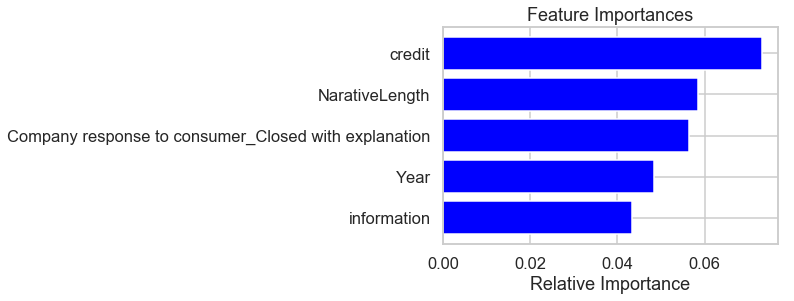

In [72]:
importances = rf.feature_importances_
indices = np.argsort(importances)
importances[indices][-5:]

#plt.plot(importances[indices].tolist())

plt.title('Feature Importances')
plt.barh(range(5), importances[indices][-5:], color='b', align='center')
plt.yticks(range(5), [col_names[i] for i in indices[-5:]])
plt.xlabel('Relative Importance')
plt.show()

#### Logistic Regression

In [73]:
# Logistic Regression Classifier
# Parameter optimization
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(msg_train,label_train)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)


start_time = time.time()

#initiate a instance for classifier using the optimized parameters
clf = LogisticRegression(**best_params)

# Fit the classifier to the training data
clf.fit(msg_train,label_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(msg_test)

scores_LR_train = cross_val_score(clf, msg_train,label_train, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, msg_test, label_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                            scores_LR_test.std()*2))
runtime = time.time() - start_time

score_train.append(scores_LR_train.mean())
score_test.append(scores_LR_test.mean())
time_all.append(runtime)

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(label_test, y_pred))
print('Classification report on the test data:')
print(classification_report(label_test, y_pred))

Best Score: 0.7809684684684685
Best Parameters: {'C': 100, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Cross Validation Accuracy Scores - Training Set: 0.78155(+/- 0.05)
Cross Validation Accuracy Scores - Test Set: 0.74256(+/- 0.06)
Confusion matrix on the test data:
[[292 105]
 [ 41  55]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.88      0.74      0.80       397
          1       0.34      0.57      0.43        96

avg / total       0.77      0.70      0.73       493



In [74]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(col_names), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']

# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on being disputed')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(10)


Features with the most impact on being disputed


,Attribute,Coef,Odds_Ratios
103,Company_BYL Collection Services,21.235500,1.669017e+09
0,15,19.765620,3.837954e+08
30,completely,15.717192,6.697149e+06
101,Sub-product_(CD) Certificate of deposit,15.268524,4.275981e+06
29,completed,12.572553,2.885297e+05
98,violation,11.154326,6.986541e+04
63,less,10.667774,4.294924e+04
87,say,10.633624,4.150729e+04
106,Company_SCOTTRADE BANK,10.319601,3.032116e+04
53,giving,10.298021,2.967384e+04


By checking the logistic regression coefficient, we can take a glance at the features that contribute most to the classification of our target. 

This is interesting information! We found:
1. The company of Scottrade Bank made it to one of top contributions to being classified as dispute. 
2. Many words, such as "refuse", "false", "violation", increase the chance of the dispute. 
3. Note that "Equifax" appears in the top three contributions. We noted ealier in this study that the spike in credit information complaint in 2017 and the Equifax's data breach in 2017. It seems that not only there were increased complaint, the company name is also one of the top 3 contributions to the complaint being disputed. 


#### Adaboost

In [75]:
# Parameter optimization
param_grid = {
              "n_estimators": [50, 100, 200]
             }


ABC = AdaBoostClassifier()

# run grid search
grid_ab = GridSearchCV(ABC, param_grid=param_grid)

grid_ab.fit(msg_train,label_train)

# Printing the best score from the model
print('Best Score:', grid_ab.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_ab.best_params_
print('Best Parameters:', best_params)



start_time = time.time()
#initiate a instance for classifier

ab = AdaBoostClassifier(**best_params)

# Fit the classifier to the training data
ab.fit(msg_train,label_train)

# Predict the labels of the test data: y_pred
y_pred = ab.predict(msg_test)

scores_ab_train = cross_val_score(ab, msg_train,label_train, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_ab_train.mean(), 
                                                                                 scores_ab_train.std()*2))
scores_ab_test = cross_val_score(ab, msg_train,label_train, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_ab_test.mean(), 
                                                                                 scores_ab_test.std()*2))
runtime = time.time() - start_time

score_train.append(scores_ab_train.mean())
score_test.append(scores_ab_test.mean())
time_all.append(runtime)

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(label_test, y_pred))
print('Classification report on the test data:')
print(classification_report(label_test, y_pred))

Best Score: 0.7702702702702703
Best Parameters: {'n_estimators': 200}
Cross Validation Accuracy Scores - Training Set: 0.80703(+/- 0.22)
Cross Validation Accuracy Scores - Test Set: 0.80703(+/- 0.22)
Confusion matrix on the test data:
[[312  85]
 [ 66  30]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.83      0.79      0.81       397
          1       0.26      0.31      0.28        96

avg / total       0.72      0.69      0.70       493



#### Model Comparison

In [76]:
models = ['Naive Bayes', 'Random Forest Classifier', 'Logistic Regression', 'AdaBoost']
model_comp = pd.DataFrame(
    {'model_name': models,
     'Accuracy score on train': score_train,
     'Accuracy score on test': score_test,
     'Time to run': time_all
    })

print(model_comp)

   Accuracy score on test  Accuracy score on train  Time to run  \
0                0.649313                 0.573224     0.023336   
1                0.795106                 0.860500     7.696938   
2                0.742556                 0.781553    10.355680   
3                0.807034                 0.807034     6.337400   

                 model_name  
0               Naive Bayes  
1  Random Forest Classifier  
2       Logistic Regression  
3                  AdaBoost  


Looks like the accuracy scores highest at 0.62 on train data by Logistic Regression. Naive Bayes scores least at 0.55. The accuracy by naive bayes did not improve but dropped compared with the model with TFIDF matrix only. 

All of the scores have close results between training data and test data. This reflects over fitting does not seem to occur in any of the models. 

In the meantime, naive bayes is the fastest to run among the models. While logistic regression is takes about 19 seconds and scores the best. Random forest classifier, due to its nature and the size of our data, takes way longer to produce output. It is important to utilize the time limit and maximize the accuracy accordingly. 

The overall accuracy score here is slightly above 0.62. While this score does not seem high, it does give insight in what features contribute to the higher possibility of complaint being diputed. That is useful information for companies to proactively work with the complaints to improve their consumer experience. 

Next we check the ROC curve of the results from above models. It will give more insight into how well the models work.

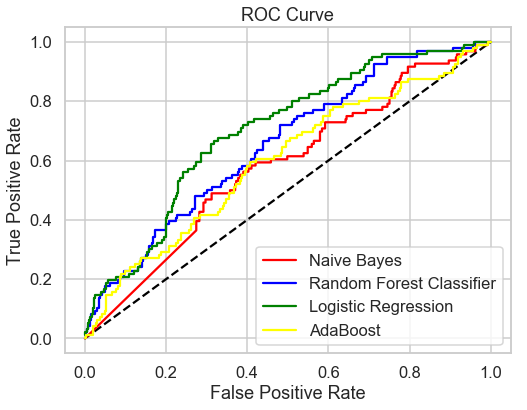

In [77]:
# prepare ROC curve plot
y_pred_prob_mnb = mnb.predict_proba(msg_test)[:,1]
y_pred_prob_rf = rf.predict_proba(msg_test)[:,1]
y_pred_prob_lg = clf.predict_proba(msg_test)[:,1]
y_pred_prob_ab = ab.predict_proba(msg_test)[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr_mnb, tpr_mnb, thresholds_mnb = roc_curve(label_test, y_pred_prob_mnb)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(label_test, y_pred_prob_rf)
fpr_lg, tpr_lg, thresholds_lg = roc_curve(label_test, y_pred_prob_lg)
fpr_ab, tpr_ab, thresholds_ab = roc_curve(label_test, y_pred_prob_ab)


# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mnb, tpr_mnb, 'red', label='Naive Bayes')
plt.plot(fpr_rf, tpr_rf, 'blue', label='Random Forest Classifier')
plt.plot(fpr_lg, tpr_lg, 'green', label='Logistic Regression')
plt.plot(fpr_ab, tpr_ab, 'yellow', label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#lgd=plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('ROC Curve')
plt.savefig('./../results/roc.png', dpi = 150)

<a id='summary'></a>
## Summary

This study took a deep dive into the financial product consumer compaints data from Consumer Financial Protection Bureau (CFPB). We put our focus on the amount of complaint received and the rate of dispute.  

A few highlights from the exploratory data analysis:  
- Credit reporting and other consumer reports, mortgage, and debt collection are the most complained products. 
- Notably, there is surge in number of complaints on credit reporting in 2017 when Equifax had its major data breach.
- There are hot/cold months of the year and day of the week for consumer complaints. The dispute rate varies as well. Colder times tend to result in higher dispute rate. 
- The analysis also shows the more rural the location is, the less chance the complaint will be disputed. Among the top complained states, Florida stands out as most complaint per capita. 
- How the company replies to the customer after the complaint plays an important role in the dipute rate. 


Next, I did feature engineering on the zip code feature by transforming it into the rurality. This utilize the zip code column without adding too much memory and computation demand of the system during machine learning process. Another feature engineering was done by finding the length of consumer narratives. These featuress then go through statistical test and significant ones were chosen for the machine learning models. Then four classification models were picked to fit, cross validate and predict the dispute rate. I used accuracy scores and ROC curves to compare these methonds. It seems random forest classifier performed best. With overall weak correlation between features and the target, we got accuracy scores as high as 0.63.  

The feature importance analysis gives insight in what features contribute to the higher possibility of complaints being diputed. That is useful information for companies to proactively work with the complaints to improve their consumer experience. 